# Style Transfer: An Overview

In simple terms, style transfer is a fascinating technique that blends the content of one image with the style of another, resulting in a unique visual synthesis. Through advanced algorithms and neural networks, it extracts the stylistic elements from one image and applies them to another, creating visually compelling compositions. In this notebook, we'll dive into the world of style transfer, exploring how we can leverage deep learning to infuse our digital creations with artistic flair.


## Imports

In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Importance of the VGG Model in Style Transfer

In the realm of style transfer, the VGG (Visual Geometry Group) model holds significant importance. This model serves as a fundamental tool for extracting crucial features from images, which are essential for separating content and style. By leveraging the pre-trained convolutional layers of the VGG model, we gain access to hierarchical representations capable of capturing both low-level and high-level features. These features play a pivotal role in isolating the content and style characteristics of our input images, thereby enabling the synthesis of visually compelling compositions through style transfer algorithms.

![VGG style and content](https://i.stack.imgur.com/RSEBP.png)

In [2]:
img_size = 720
VGG_Model = tf.keras.applications.VGG19(
    input_shape=(img_size,img_size,3),
    include_top=False,
    weights='imagenet'
)
VGG_Model.trainable = False

## Content Cost function
The content cost function measures the difference between the feature representations of the content image and the generated image at a chosen layer of a pre-trained neural network, such as VGG. It quantifies how much the content of the generated image deviates from that of the content image, helping ensure the preservation of essential content while applying desired style.

In [3]:
def compute_content_cost(content_output, generated_output):

    a_C = content_output[-1]
    a_G = generated_output[-1]
    m, n_H, n_W, n_C = a_C.get_shape().as_list()
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C])
    
   
    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)
    
    return J_content

#### Choosing the content layer

In [4]:
content_layer = [('block5_conv4', 1)]

### Gram matrix

The Gram matrix is crucial in style measurement because it captures correlations between features in a neural network. By summarizing these correlations, it represents the style of an image in terms of texture, color, and patterns. Importantly, it does this regardless of the image's content. In style transfer, comparing Gram matrices of style and generated images allows for style similarity measurement, ensuring the generated image adopts the style of the style image.

In [5]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

## Style Cost function

The style cost function evaluates the difference in style between a style image and a generated image by comparing their respective feature correlations across multiple layers of a pre-trained neural network, like VGG. It computes the mean squared difference between the Gram matrices of the style image and the generated image at each chosen layer, capturing the statistical properties of texture, color, and patterns. This process enables the generated image to adopt the stylistic characteristics of the style image while maintaining its content

In [6]:
def compute_layer_style_cost(a_S, a_G):
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))
     
    return J_style_layer

### Choosing the style layers

In [7]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)
    ]

### Computing the Style cost for all layers

In [8]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):

    J_style = 0
    a_S = style_image_output[:-1]

    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        J_style += weight[1] * J_style_layer

    return J_style

## Computing the Total Cost

The total cost function in style transfer combines both the content cost and the style cost using hyperparameters alpha and beta. The content cost ensures the generated image retains the content of the original, while the style cost ensures it adopts the style of the desired image. Alpha and beta control the relative importance of content and style in the final output. By adjusting these hyperparameters, users can fine-tune the balance between preserving content and applying style, resulting in visually appealing synthesized images.

In [20]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

## Putting it all together

#### The content image
to use your content replace the image in data/content.jpg with your content image

(1, 720, 720, 3)


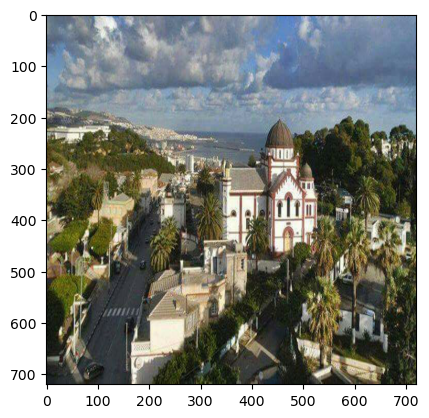

In [10]:
content_image = np.array(Image.open("data/content.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
plt.imshow(content_image[0])
plt.show()

#### The Style image
to use your own style replace the image in data/style.jpg with your style image

(1, 720, 720, 3)


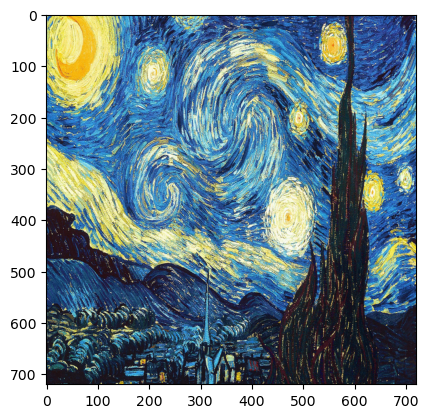

In [11]:
style_image = np.array(Image.open("data/style.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
plt.imshow(style_image[0])
plt.show()

#### initialising the generated image

(1, 720, 720, 3)


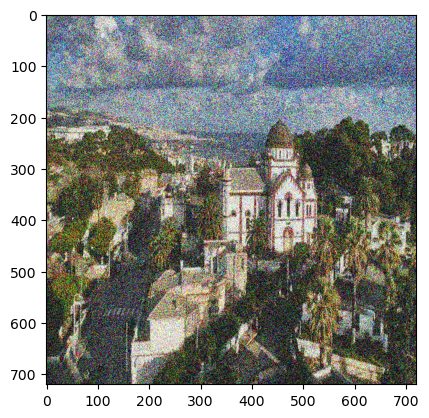

In [12]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.5, 0.5)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
plt.imshow(generated_image.numpy()[0])
plt.show()

#### function to build a model based on the input and selected  layers (from our pretrained VGG)

In [13]:
def get_layer_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    
    model = tf.keras.Model([vgg.input], outputs)
    return model

#### define a new model based on the pretrained VGG with only the style,content and input layers

In [14]:
vgg_model_outputs = get_layer_outputs(VGG_Model, STYLE_LAYERS + content_layer)

#### retreive the content and style from the content and style images

In [15]:
content_target = vgg_model_outputs(content_image)  
style_targets = vgg_model_outputs(style_image)

#### Convert the images into vectors

In [16]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

### Trainning Setup

In [17]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_image)
        J_style = compute_style_cost(a_S, a_G)
        J_content = compute_content_cost(a_C, a_G)
        J = total_cost(J_content, J_style)
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return J

we convert the `generated_image` tensor into a TensorFlow Variable using the `tf.Variable()` function. This conversion is necessary to enable TensorFlow to track gradients with respect to this variable during training.

In [18]:
generated_image = tf.Variable(generated_image)

### Trainning the model

Epoch 0
Epoch 0 


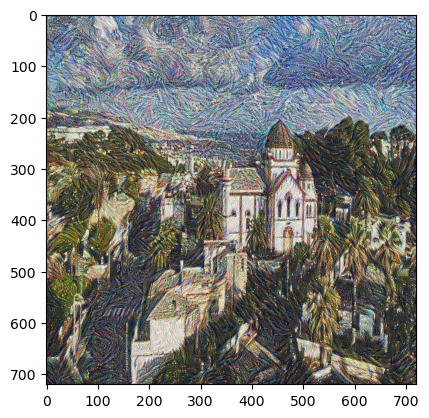

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 5 


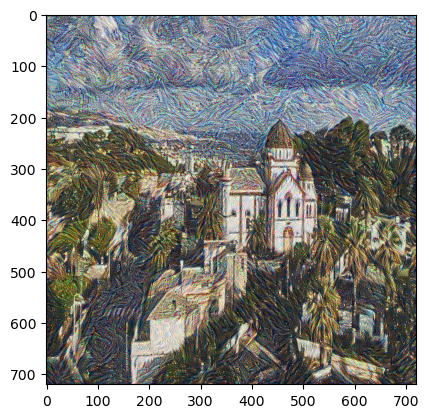

Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 10 


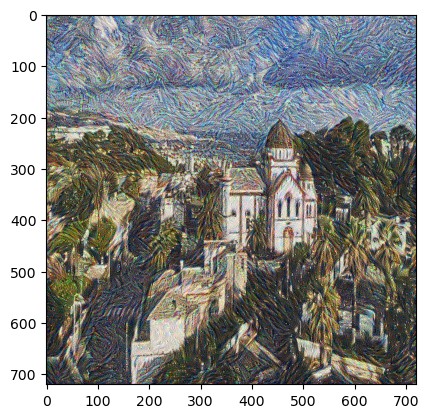

Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 15 


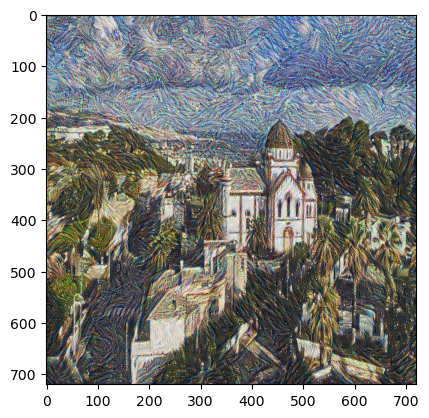

Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 20 


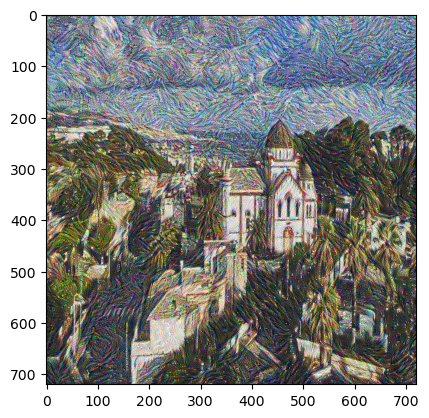

Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 25 


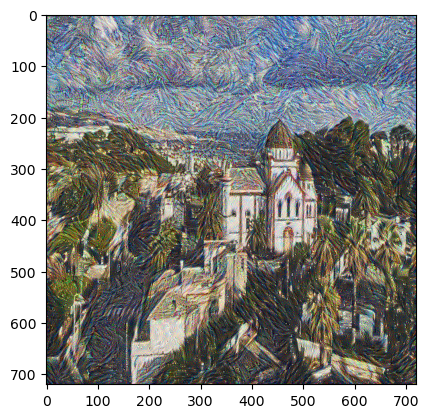

Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 30 


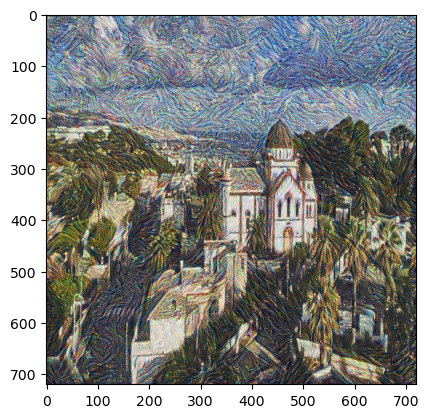

Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 35 


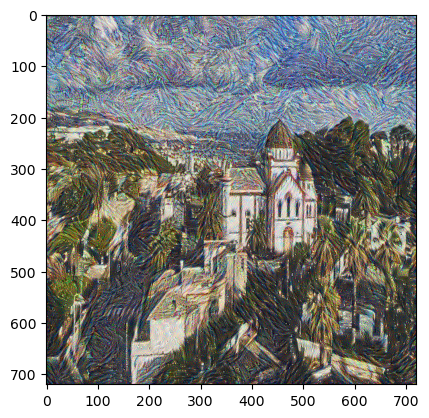

Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 40 


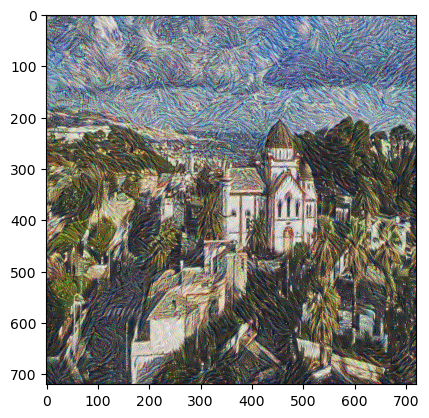

Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 45 


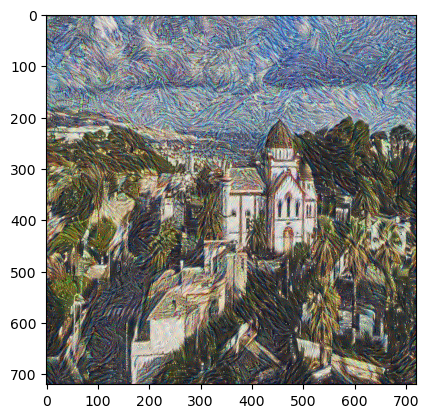

Epoch 46
Epoch 47
Epoch 48
Epoch 49


In [21]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

epochs = 50
for i in range(epochs):
    print(f"Epoch {i}")
    train_step(generated_image)
    if i % 5 == 0:
        print(f"Epoch {i} ")
        image = tensor_to_image(generated_image)
        plt.imshow(image)
        plt.show() 